In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [41]:
data = pd.read_excel('Data/Olson_Wu_Sun_2014_Epistasis_Dataset.xlsx', usecols='B:K', header=0, skiprows=2)
data.insert(10,  'Double Fitness',
            np.log((data['Selection Count']/data['Input Count'])/(3041819/1759616)))
data.insert(11,  'Epistasis',
            data['Double Fitness']-data['Mut1 Fitness']-data['Mut2 Fitness'])
df = data.drop(['Input Count', 'Selection Count', 'Mut1 WT amino acid', 'Mut2 WT amino acid'], axis=1)
data = df
data['Mut1 Fitness'] = np.log(data['Mut1 Fitness'])
data['Mut2 Fitness'] = np.log(data['Mut2 Fitness'])

AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
AA_dict = dict((k,v) for v,k in enumerate(AA))

for col in ['Mut1 Mutation', 'Mut2 Mutation']:
    data[col] = list(map(AA_dict.get, data[col]))

c:\Users\leera\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\leera\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
with open('Data/GB1.txt', 'r', encoding='utf-8') as f:
    seq = f.readlines()[1].strip()
print(f'seq sequence: {seq}')
print(f'seq length: {len(seq)}')
print(f'Number of total double mutants: {data.shape[0]}')
print(f'Theoretical number of double mutants: 55*54/2*(19*19)={int(55*54/2*(19*19))}')
print(f'Number of mutants with zero expression: {int(55*54/2*(19*19))-data.shape[0]}')
data.head()

,Mut1 Position,Mut1 Mutation,Mut2 Position,Mut2 Mutation,Mut1 Fitness,Mut2 Fitness,Double Fitness,Epistasis
0,2,0,3,0,0.417394,-0.546453,-2.204144,-2.075085
1,2,0,3,1,0.417394,-0.484508,-1.358290,-1.291176
2,2,0,3,2,0.417394,-4.605170,-4.043868,0.143909
3,2,0,3,3,0.417394,-4.710531,-4.824026,-0.530889
4,2,0,3,4,0.417394,0.052592,0.342497,-0.127489


<Axes: xlabel='Epistasis', ylabel='Count'>

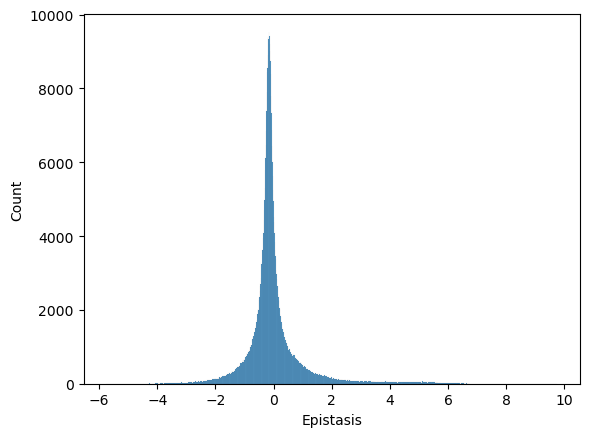

In [52]:
fig, ax = plt.subplots()
sns.histplot(data=data['Epistasis'], ax=ax)

In [67]:
single_df = data[['Mut1 Position', 'Mut1 Mutation', 'Mut1 Fitness']].drop_duplicates()
single_df = single_df.sort_values(by=['Mut1 Position', 'Mut1 Mutation'])

In [44]:

embedding_single_mutations = pd.read_csv('Data/mutation_input/single_mutations.csv', 
                                         usecols=[0,1], dtype='int', names=['Mut1 Position', 'Mut1 Mutation', 'Mut1 Fitness'])
embedding_single_data = pd.read_csv('Data/embedding_output/final_cell_single_mutations.csv')
embedding_concat = pd.concat([embedding_single_mutations, embedding_single_data], axis=1)
embedding_concat = embedding_concat.sort_values(by=['Mut1 Position', 'Mut1 Mutation'])
X = embedding_concat.iloc[:,2:].to_numpy()
y = single_df['Mut1 Fitness'].to_numpy().reshape(-1,1)

In [70]:
conda install scikit-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\leera\anaconda3

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-1.2.2         |   py39hd77b12b_0         6.5 MB
    ------------------------------------------------------------
                                           Total:         6.5 MB

The following packages will be UPDATED:

  scikit-learn                         1.2.1-py39hd77b12b_0 --> 1.2.2-py39hd77b12b_0 None




scikit-learn-1.2.2   | 6.5 MB    |            |   0% 
scikit-learn-1.2.2   | 6.5 MB    | 6          |   7% 
scikit-learn-1.2.2   | 6.5 MB    | ###3       |  33% 
scikit-learn-1.2.2   | 6.5 MB    | ######2    |  62% 
scikit-learn-1.2.2   | 6.5 MB    | #########1 |  91% 
scikit-learn-1.2.2   | 6.5 MB    | ########## | 100% 
Preparing transaction: ...working... done
Ve



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda


